# Double Pendulum Trajectory Forecasting using RNN
Omkar Thawakar , SGGSIE&T Nanded

In [5]:
#What are we working with?
import sys
sys.version

'3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [6]:
#Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn


In [4]:
#TF Version
tf.__version__

'1.3.0'

In [3]:

# for each experiment value of l1,l2,m1,m2 and th1,th2,w1,w2 are same so explicitely add these features after training.

G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg


def derivs(state, t):

    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    del_ = state[2] - state[0]
    den1 = (M1 + M2)*L1 - M2*L1*cos(del_)*cos(del_)
    dydx[1] = (M2*L1*state[1]*state[1]*sin(del_)*cos(del_) +
               M2*G*sin(state[2])*cos(del_) +
               M2*L2*state[3]*state[3]*sin(del_) -
               (M1 + M2)*G*sin(state[0]))/den1

    dydx[2] = state[3]

    den2 = (L2/L1)*den1
    dydx[3] = (-M2*L2*state[3]*state[3]*sin(del_)*cos(del_) +
               (M1 + M2)*G*sin(state[0])*cos(del_) -
               (M1 + M2)*L1*state[1]*state[1]*sin(del_) -
               (M1 + M2)*G*sin(state[2]))/den2

    return dydx

# create a time array from 0..100 sampled at 0.05 second steps
dt = 0.1
t = np.arange(0.0, 100, dt)

# th1 and th2 are the initial angles (degrees)
# w10 and w20 are the initial angular velocities (degrees per second)

th1 = 120.0
w1 = 0.0
th2 = 0.0
w2 = 0.0

# initial state
state = np.radians([th1, w1, th2, w2])

# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)

x1 = L1*sin(y[:, 0])
y1 = -L1*cos(y[:, 0])

#print("x1 : ",x1)
#print("y1 : ",y1)

x2 = L2*sin(y[:, 2]) + x1
y2 = -L2*cos(y[:, 2]) + y1

#print("x2 : ",x2)
#print("y2 : ",y2)

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),interval=25, blit=True, init_func=init)



NameError: name 'integrate' is not defined

#### Generate some data

length of test data :  1000
(1000, 1)
length of test data :  912
(912, 1)


/Users/omkarchakradharthawakar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


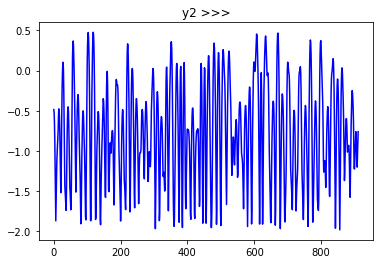

In [7]:
random.seed(111)
rng = pd.date_range(start='2000', periods=9, freq='M')
ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()

#ts.head(10)

f = open("data/y2.txt" , "r")
t = open("data/time_slots.txt" , "r")
array1 = []
array2 = []

for line in f.read().split('\n') :
  array1.append(line )
for line in t.read().split('\n') :
  array2.append(line )
f.close()
t.close()
array1.pop()
array2.pop()
data = []

for i in range(len(array1)):
    data.append([array1[i]])
test = np.array(data)
mylist = test.astype(np.float)

print("length of test data : ",len(mylist))
print(mylist.shape)
mylist.reshape(1,-1)
#print(mylist)

ts = np.delete(mylist,[i for i in range(912,1001)],0)

print("length of test data : ",len(ts))
print(ts.shape)
ts.reshape(1,-1)
#print(ts)

plt.plot(ts,c='b')
plt.title('y2 >>>')
plt.show()



#### Convert data into array that can be broken up into training "batches" that we will feed into our RNN model.  Note the shape of the arrays. 

In [8]:
TS = np.array(ts)
num_periods = 100
f_horizon = 1  #forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
print(x_data.shape)
x_batches = x_data.reshape(-1, 100, 1)
print (len(x_batches))
print (x_batches.shape)
#print ("x_batches : ",x_batches)
y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
print(y_data.shape)
y_batches = y_data.reshape(-1, 100, 1)


print ("y_batches : ",y_batches)
print (y_batches.shape)

(900, 1)
9
(9, 100, 1)
(900, 1)
y_batches :  [[[ -5.24476449e-01]
  [ -6.48676966e-01]
  [ -8.71019532e-01]
  [ -1.20275951e+00]
  [ -1.62066548e+00]
  [ -1.86911222e+00]
  [ -1.59735687e+00]
  [ -1.31756139e+00]
  [ -1.13473550e+00]
  [ -1.02169831e+00]
  [ -9.32942575e-01]
  [ -8.55187067e-01]
  [ -7.49839803e-01]
  [ -5.67737096e-01]
  [ -4.75580003e-01]
  [ -4.92185552e-01]
  [ -5.85496494e-01]
  [ -7.55875900e-01]
  [ -1.01412612e+00]
  [ -1.29605878e+00]
  [ -1.51912616e+00]
  [ -1.38845605e+00]
  [ -8.96292936e-01]
  [ -4.91861962e-01]
  [ -2.08158459e-01]
  [ -2.10590930e-02]
  [  8.99717824e-02]
  [  1.03748882e-01]
  [ -1.26967951e-02]
  [ -2.78601145e-01]
  [ -6.96712328e-01]
  [ -1.18360217e+00]
  [ -1.42744340e+00]
  [ -1.51295215e+00]
  [ -1.57100333e+00]
  [ -1.66760359e+00]
  [ -1.74005964e+00]
  [ -1.47478390e+00]
  [ -1.10170996e+00]
  [ -7.99786295e-01]
  [ -5.89758230e-01]
  [ -4.72670174e-01]
  [ -4.50507424e-01]
  [ -5.26004251e-01]
  [ -6.99907560e-01]
  [ -9.653

#### Pull out our test data

In [9]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 100, 1)
    testY = TS[-(num_periods):].reshape(-1, 100, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods )
print (X_test.shape)
#print (X_test)
print (Y_test.shape)


(1, 100, 1)
(1, 100, 1)


In [10]:
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

num_periods = 100      #number of periods per vector we are using to predict one period ahead
inputs = 1            #number of vectors submitted
hidden = 100          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()           #initialize all the variables

In [11]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter("outputs_y", sess.graph)
    print(sess.run(init))
    writer.close()

None


In [12]:
epochs = 2000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation
errors = []
iterations = []
with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        errors.append(loss.eval(feed_dict={X: x_batches, y: y_batches}))
        iterations.append(ep)
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)  
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)
    

0 	MSE: 590.14
100 	MSE: 16.4718
200 	MSE: 8.35422
300 	MSE: 5.62936
400 	MSE: 4.1909
500 	MSE: 3.1443
600 	MSE: 2.49152
700 	MSE: 2.31495
800 	MSE: 1.78809
900 	MSE: 1.6103
1000 	MSE: 1.82122
1100 	MSE: 1.33001
1200 	MSE: 1.69053
1300 	MSE: 1.08325
1400 	MSE: 0.990443
1500 	MSE: 0.941035
1600 	MSE: 0.875769
1700 	MSE: 0.824849
1800 	MSE: 0.755943
1900 	MSE: 0.84907
[[[-1.03808737]
  [-1.09802735]
  [-1.41036034]
  [-1.68198133]
  [-1.25392604]
  [-0.64153349]
  [-0.56519186]
  [-0.59009707]
  [-0.4054929 ]
  [-0.48430419]
  [-0.60694289]
  [-0.74027896]
  [-1.04396391]
  [-1.54080594]
  [-1.6718967 ]
  [-1.05013919]
  [-0.9367907 ]
  [-0.67957836]
  [-0.31416181]
  [-0.08559561]
  [-0.03424519]
  [-0.02150482]
  [-0.02602568]
  [ 0.03959051]
  [ 0.16592529]
  [ 0.15816128]
  [-0.04497784]
  [-0.27259976]
  [-0.52009916]
  [-0.9714936 ]
  [-1.56786144]
  [-1.90774345]
  [-1.59103942]
  [-1.18436611]
  [-0.68536532]
  [-0.35733527]
  [-0.19620407]
  [-0.09706205]
  [-0.12983972]
  [-0.2

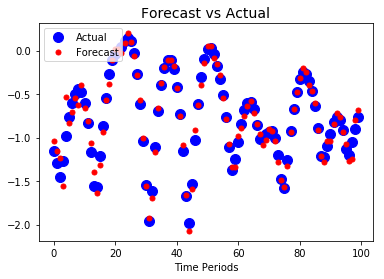

In [14]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()



(2000,)


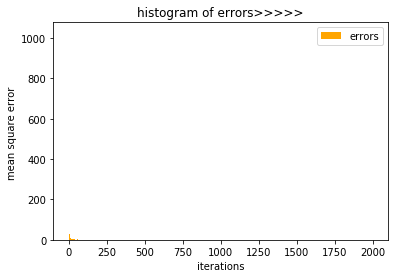

In [15]:
#!/usr/bin/env python
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

errors=np.array(errors)
iterations=np.array(iterations)
print(errors.shape)
#print(errors)

plt.hist(errors,iterations,label='errors', facecolor='orange')

plt.xlabel('iterations')
plt.ylabel('mean square error ')
plt.title('histogram of errors>>>>>')
plt.legend()
plt.show()

(2000,)


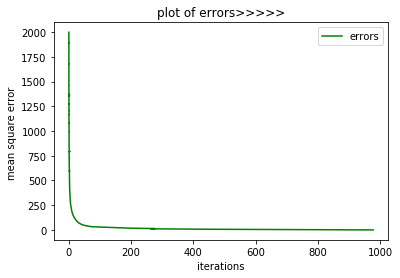

In [16]:
#!/usr/bin/env python
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

errors=np.array(errors)
iterations=np.array(iterations)
print(errors.shape)
#print(errors)

plt.plot(errors,iterations,label='errors',color='green')

plt.xlabel('iterations')
plt.ylabel('mean square error ')
plt.title('plot of errors>>>>>')
plt.legend()
plt.show()